<a id='Toc'></a>

## Classification Metrics demystified!

You have a model and some predictions now what? Read on!

##### Table of contents

* <a href="#pre" style='color:#a52a2a'>Preprocessing</a>
* <a href="#one" style='color:#a52a2a'>One-hot encoding</a>
* <a href="#acc" style='color:#a52a2a'>Metrics</a>
    * <a href="#acc" style='color:#dc143c'>Accuracy</a>
    * <a href="#thr" style='color:#dc143c'>Threshold Moving</a>
    * <a href="#con" style='color:#dc143c'>Confusion Matrix</a>
    * <a href="#prec" style='color:#dc143c'>Precision and recall</a>
    * <a href="#roc" style='color:#dc143c'>ROC and AUC</a>
        * <a href="#roc_c" style='color:#dc143c'>ROC curve</a>
        * <a href="#auc" style='color:#dc143c'>AUC</a>
        * <a href="#sum" style='color:#dc143c'>Summary - AUC</a>
* <a href="#thre" style='color:#a52a2a'>Threshold moving - Enhanced</a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, auc
from IPython.display import display
from sklearn.feature_extraction import DictVectorizer
from tqdm import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

# from jupyterthemes import jtplot
# jtplot.style(context='notebook', ticks=True, grid=False)

%matplotlib inline

In [2]:
# load data

churn_df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

churn_df.shape

(7043, 21)

<a id='pre'></a>

### Preprocessing

In [3]:
churn_df.head().T

,0,1,2,3,4
customerID,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,Female,Male,Male,Male,Female
SeniorCitizen,0,0,0,0,0
Partner,Yes,No,No,No,No
Dependents,No,No,No,No,No
tenure,1,34,2,45,2
PhoneService,No,Yes,Yes,No,Yes
MultipleLines,No phone service,No,No,No phone service,No
InternetService,DSL,DSL,DSL,DSL,Fiber optic
OnlineSecurity,No,Yes,Yes,Yes,No


In [4]:
churn_df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
# unifying naming conventions
churn_df.columns = churn_df.columns.str.lower().str.replace(' ', '_')

# update dtypes
churn_df.churn = churn_df.churn.eq('Yes').mul(1)

churn_df.totalcharges = pd.to_numeric(churn_df.totalcharges, errors='coerce')

# identifying categorical columns
cat_cols = churn_df.select_dtypes('object').columns[1:] # execluding customerid

for col in cat_cols:
    churn_df[col] = churn_df[col].str.lower().str.replace(' ', '_')

In [6]:
# check for empty cells
churn_df.isnull().sum()

customerid           0
gender               0
seniorcitizen        0
partner              0
dependents           0
tenure               0
phoneservice         0
multiplelines        0
internetservice      0
onlinesecurity       0
onlinebackup         0
deviceprotection     0
techsupport          0
streamingtv          0
streamingmovies      0
contract             0
paperlessbilling     0
paymentmethod        0
monthlycharges       0
totalcharges        11
churn                0
dtype: int64

In [7]:
# fill empty cells
churn_df.totalcharges = churn_df.totalcharges.fillna(0)

In [8]:
churn_df.head().T

,0,1,2,3,4
customerid,7590-VHVEG,5575-GNVDE,3668-QPYBK,7795-CFOCW,9237-HQITU
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [9]:
# check cardinality of all cat features
churn_df[cat_cols].nunique()

gender              2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [10]:
list(churn_df.paymentmethod.unique())

['electronic_check',
 'mailed_check',
 'bank_transfer_(automatic)',
 'credit_card_(automatic)']

Cardinality refers to the number of unique records (levels) in a given categorical feature. For example, *payment method* feature has 4 unique levels.

In [11]:
# check distribution of target variable
churn_df.churn.value_counts(normalize=True).round(2)

0    0.73
1    0.27
Name: churn, dtype: float64

In [12]:
# churn priori
priori = churn_df.churn.mean().round(2)

priori

0.27

This is an imbalanced classification problem as there are fewer number of positive observations (churn) compared to negative ones, which means that:

- Cross validation framework need to consider class imbalance
- Some evaluation metrics may be misleading

In [13]:
# establishing validation framework

feats = churn_df.drop(['customerid', 'churn'], axis = 1)
labels = churn_df.churn

x_train, x_test, y_train, y_test = train_test_split(feats, labels, stratify = labels, test_size = 0.2, random_state = 1)

Using stratified sampling ensures that train and test sets have equal number of positive observations.

In [14]:
# Distribution of positive observations in both sets
display(y_train.value_counts(normalize=True).round(2), y_test.value_counts(normalize=True).round(2))

0    0.73
1    0.27
Name: churn, dtype: float64

0    0.73
1    0.27
Name: churn, dtype: float64

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='one'></a>

### One-hot encoding

Assigning numeric representations for categorical features (i.e. 1 for 'yes' and 0 'no').

In [15]:
# save rows as dict to feed dict vectorizer
tr_dict = x_train[feats.columns].to_dict(orient='records')
ts_dict = x_test[feats.columns].to_dict(orient='records')

In [16]:
# each row is now a dict record
tr_dict[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'tenure': 1,
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'monthlycharges': 102.45,
 'totalcharges': 102.45}

In [17]:
# sparse false to return a vector of 0 and 1
dv = DictVectorizer(sparse=False)

# Transform
x_train = dv.fit_transform(tr_dict)
x_test = dv.transform(ts_dict)

In [18]:
# feature vector and shape after OHE
print('feature vector: ',list(x_train[0]), '\n', '-'*40, '\n', 'n-cols OHE: ', x_train.shape[1], '\n', '-'*40, '\n', 
      'n-cols original: ', churn_df.shape[1], sep='')

feature vector: [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 102.45, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 102.45]
----------------------------------------
n-cols OHE: 45
----------------------------------------
n-cols original: 21


In [19]:
# feature names
print(dv.get_feature_names(),)

['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'dependents=no', 'dependents=yes', 'deviceprotection=no', 'deviceprotection=no_internet_service', 'deviceprotection=yes', 'gender=female', 'gender=male', 'internetservice=dsl', 'internetservice=fiber_optic', 'internetservice=no', 'monthlycharges', 'multiplelines=no', 'multiplelines=no_phone_service', 'multiplelines=yes', 'onlinebackup=no', 'onlinebackup=no_internet_service', 'onlinebackup=yes', 'onlinesecurity=no', 'onlinesecurity=no_internet_service', 'onlinesecurity=yes', 'paperlessbilling=no', 'paperlessbilling=yes', 'partner=no', 'partner=yes', 'paymentmethod=bank_transfer_(automatic)', 'paymentmethod=credit_card_(automatic)', 'paymentmethod=electronic_check', 'paymentmethod=mailed_check', 'phoneservice=no', 'phoneservice=yes', 'seniorcitizen', 'streamingmovies=no', 'streamingmovies=no_internet_service', 'streamingmovies=yes', 'streamingtv=no', 'streamingtv=no_internet_service', 'streamingtv=yes', 'techsupport=no

Each level (i.e.: gender: male/female) is now separated into several features depending on number of unique records. Note that we did not drop one level (similar to 'drop_first' in get_dummies) because we'll use logistic regression model and coefficients will be canceled when features are absent.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='tra'></a>

### Train model

In [20]:
# learn from data
model = LogisticRegression(random_state = 1)
model.fit(x_train, y_train)

LogisticRegression(random_state=1)

In [21]:
# generate probabilistic predictions
y_pred = model.predict_proba(x_test)[:, 1]
y_pred.round(2)

array([0.24, 0.5 , 0.32, ..., 0.51, 0.02, 0.14])

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='acc'></a>

### Metrics 

#### Accuracy

Accuracy measures portion of correct predictions, existence of class imbalance reduce the credibility of this metrics.

In [22]:
# accuracy score using default classification threshold (0.5)
(y_test == (y_pred >= 0.5)).mean().round(2)

0.81

In [23]:
# accuracy score sklean
accuracy_score(y_test, y_pred >= 0.5).round(2)

0.81

In [24]:
# instantiating classification thresholds
t = np.linspace(0, 1, 20)
t

array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])

In [25]:
# threshold moving

accuracy = []

for _ in t:
    acc = accuracy_score(y_test, y_pred >= _)
    accuracy.append(acc)
    print('Threshold: ', _.round(2), '--> Accuracy: ', acc.round(2))

Threshold:  0.0 --> Accuracy:  0.27
Threshold:  0.05 --> Accuracy:  0.51
Threshold:  0.11 --> Accuracy:  0.61
Threshold:  0.16 --> Accuracy:  0.67
Threshold:  0.21 --> Accuracy:  0.71
Threshold:  0.26 --> Accuracy:  0.74
Threshold:  0.32 --> Accuracy:  0.77
Threshold:  0.37 --> Accuracy:  0.78
Threshold:  0.42 --> Accuracy:  0.8
Threshold:  0.47 --> Accuracy:  0.81
Threshold:  0.53 --> Accuracy:  0.81
Threshold:  0.58 --> Accuracy:  0.8
Threshold:  0.63 --> Accuracy:  0.79
Threshold:  0.68 --> Accuracy:  0.78
Threshold:  0.74 --> Accuracy:  0.77
Threshold:  0.79 --> Accuracy:  0.75
Threshold:  0.84 --> Accuracy:  0.74
Threshold:  0.89 --> Accuracy:  0.73
Threshold:  0.95 --> Accuracy:  0.73
Threshold:  1.0 --> Accuracy:  0.73


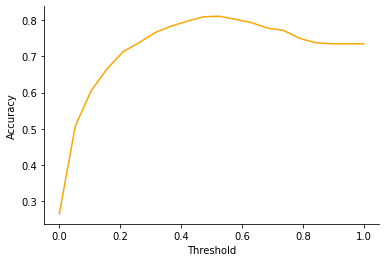

In [26]:
# visualizing accuracy score at different classification thresholds

plt.figure(figsize=(6, 4))

# plot
plt.plot(t, accuracy, color='orange')

# decorate
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False);

In [27]:
# class distribution
print('Positive observations: ', 1 - y_test.mean().round(2), '\n','Negative observations: ', y_test.mean().round(2), sep='')

Positive observations: 0.73
Negative observations: 0.27


**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='thr'></a>

#### Threshold Moving

Addressing class imbalance issue in a simple and straight forward way can be done by Threshold Moving. Threshold, referred to as *t* from now on, is a decision boundary; some classifiers are capable of generating probabilistic predictions for class membership rather than pure labels (negative 0 , positive 1), *t* is then used to map these probabilistic predictions to a corresponding class label. Default *t* is 0.5 which means that observations having prediction probabilities >= 0.5 are classified as being a positive class; default *t* is not always the optimal classification decision and we can control this by threshold moving.

Threshold moving is simply changing the default *t* to whatever works best for our problem. We've selected 20 thresholds and calculated accuracy score at each, noting following:

- Accuracy scores at *t* 0 and 1 are exactly the same as class distribution, because *t* = 0 means that we classify all observations as positive class which represent only limited portion (27%) of all observations, thus, accuracy will be equal to the size of these observations and vice versa.

- Default classification threshold is indeed the one that maximizes our metric (accuracy score), however, this does not always hold true.

As we learn about other metrics we will explore further how to fully utilize *t* moving in making an informed classification decision.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='con'></a>

#### Confusion Matrix

Before discussing confusion matrix (CM) let's first understand the underlying components, when comparing actual vs predicted results a single observation falls under one of the following 4 categories:

- True positive (TP): actual observation belongs to the positive class (1) and is correctly predicted as being positive.
- False positive (FP): actual observation belongs to the negative class (0) and is wrongly predicted as being positive.
- True negative (TN): actual observation belongs to the negative class (0) and is correctly predicted as being negative.
- False negative (FN): actual observation belongs to the positive class (1) and is wrongly predicted as being negative.

If we think of binary classification problem in terms of hypothesis testing (although they are both different), we can consider that false positive and false negative categories are Type I and Type II errors respectively, in hypothesis testing terms these errors means the following:

- Type I error: rejecting null hypothesis (accepting alternative instead of null) that is actually true (giving positive affirmation to reject null).
- Type II error: failing to reject null hypothesis (accepting null instead of alternative) that is actually false.

Confusion matrix does a pretty good job clearing any 'confusion' that the above might have caused. It displays the results of the 4 categories as shown in the below table.


| Actual/Pred |        No         |        Yes      |
|-------------|-------------------|-----------------|
|  No         | 'True Negative'   | 'False Positive'|
|  Yes        | 'False Negative'  | 'True Positive' |

Note that not all confusion matrices display results in same order, we are using the same order as in scikit-learn's confusion matrix where columns represent predictions and rows are actuals.

I personally find confusion matrix to be revealing, it's a must have assessment tool beside any other chosen metric.

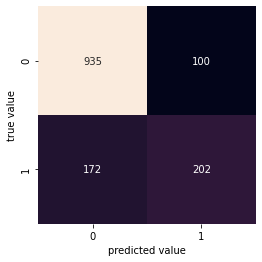

In [28]:
# CM

# predictions as pure class labels to feed CM
y_pred_class = model.predict(x_test)

cm = confusion_matrix(y_test, y_pred_class)
sns.heatmap(cm, square=True, annot=True, fmt='g', cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

In [29]:
# capturing values
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_class).ravel()

print('True Negative: ', tn, '\n', '-' * 40, '\n', 'False Positive: ', fp, '\n', '-' * 40, '\n',  
      'False Negative: ', fn, '\n', '-' * 40, '\n', 'True Positive: ', tp, sep='')

True Negative: 935
----------------------------------------
False Positive: 100
----------------------------------------
False Negative: 172
----------------------------------------
True Positive: 202


In [30]:
# class distribution in test set
y_test.value_counts()

0    1035
1     374
Name: churn, dtype: int64

What do these numbers tell us?

- 202 out of 374 positive observations are correctly predicted as being positive (TP), while 172 are wrongly predicted as being negative (FN) 

- 935 out of 1035 negative observations are correctly predicted as being negative (TN), while 100 wrongly predicted as being  positive (FP) 

We can also calculate Accuracy score from CM as follows:
- Correct predictions / all predictions = (TP + TN) / (TP + FN + FP + TP) = (935 + 202) / (935 + 172 + 100 + 202) = .81

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='prec'></a>

#### Precision and recall

We can extract other meaningful metrics from confusion matrix such as precision and recall. Precision answers 'how many positive predictions (pred = 1) are correct?' and recall answers to 'Of all positive observations (churn = 1) how many did we predict correctly?', the former measures how likely our predictions to be correct while the latter measures the completeness of our predictions.

In [31]:
# precision and recall

pr = tp / (tp + fp)
rec = tp / (tp + fn)

print('Precision: ', pr.round(2), '\n','Recall: ', rec.round(2), sep = '')

Precision: 0.67
Recall: 0.54


In [32]:
# precision and recall from CM

recall = confusion_matrix(y_test, y_pred_class, normalize = 'true').ravel()

precision = confusion_matrix(y_test, y_pred_class, normalize = 'pred').ravel()

print('Precision: ', precision[-1].round(2), '\n','Recall: ', recall[-1].round(2), sep = '')

Precision: 0.67
Recall: 0.54


In [33]:
# Classification report and CM

print('-' * 40, '\n', 'Classification Report','\n', '-' * 40, '\n', classification_report(y_test, y_pred_class), 
      '-' * 40, '\n', 'Confusion Matrix','\n', '-' * 40, '\n', confusion_matrix(y_test, y_pred_class), sep = '')

----------------------------------------
Classification Report
----------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.67      0.54      0.60       374

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.80      0.81      0.80      1409
----------------------------------------
Confusion Matrix
----------------------------------------
[[935 100]
 [172 202]]


Now we need to pause and make sense of all this. We started out with a very promising accuracy score of 81%, and ended up with poor recall score of 54%; what happened in between?

Accuracy is a misleading performance metric in imbalanced classification problems, simply because negative observations shadow the calculation due to their abundance. On the other hand, precision and recall portrays a much clearer picture of classifier performance; we can observe that only 54% of positive observations were captured by our model this means that we missed on 46% of our churning customers, pretty significant if we actually wanted to retain these customers!

There will always be a tradeoff between precision and recall metrics, whether to strike a balance between both or maximize one at the expense of the other is what threshold moving and cost matrix can help with. This will be the closing topic of our discussion. 

Notes:
- We often ignore precision and recall calculation for negative class, rather focus on calculations related to the positive class because this is the class we are actually interested in.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='roc'></a>

#### ROC and AUC

Receiver operating characteristic curve (ROC curve) is a graphical depiction of model's discriminatory power at different classification thresholds; Area under the curve (AUC) is, well, the area under ROC curve! Think of the area as a single measurement of model's discriminatory power based on model's ability to weight positive observations higher than negative ones when making predictions, hold on to this thought for now it will eventually make sense!    

Let's start with how to build an ROC curve? We need to calculate the following at each classification threshold:

- True positive rate (TPr) = Sensitivity = Recall = TP / (TP + FN)
- False positive rate (FPr) = FP / (FP + TN)

Notes:

- TPr focus on (churn = 1), second row of CM. ---> *Of all Positive observations how many are predicted correctly?*
- FPr focus on (churn = 0), first row of CM. ---> *Of all Negative observations how many are predicted incorrectly?*
- TPr is Recall, sometimes referred to as Sensitivity.
- ROC is not effective in case of class imbalance because FPr is shadowed by TN value given the fact that there are way more negative observations than positive ones; Precision-Recall curve is better when imbalance exists.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='roc_c'></a>

##### ROC curve

In [34]:
# Building ROC curve

def rates_df(y_test, y_pred, t):
    """ calculate CM, TPr and FPr at different classification thresholds """

    rates = [] # TPr and FPr

    for _ in t:
        # assigning class label above given threshold
        y_pred_c = (y_pred >= _).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_c).ravel()
        tpr = tp / (tp + fn)
        fpr = fp / (fp + tn)
        rates.append((_, tp, tn, fn, fp, tpr, fpr))

    # rates dataframe
    df = pd.DataFrame(rates, columns = ['threshold', 'tp', 'tn', 'fn', 'fp', 'tpr', 'fpr'])
    
    return df

# basic model 

t = np.linspace(0, 1, 101) # thresholds

rates_df_bsc = rates_df(y_test, y_pred, t)

rates_df_bsc[::10].round(3)

,threshold,tp,tn,fn,fp,tpr,fpr
0,0.0,374,0,0,1035,1.000,1.000
10,0.1,344,495,30,540,0.920,0.522
20,0.2,311,685,63,350,0.832,0.338
30,0.3,277,794,97,241,0.741,0.233
40,0.4,242,870,132,165,0.647,0.159
50,0.5,202,935,172,100,0.540,0.097
60,0.6,150,978,224,57,0.401,0.055
70,0.7,77,1013,297,22,0.206,0.021
80,0.8,18,1033,356,2,0.048,0.002
90,0.9,0,1035,374,0,0.000,0.000


We've calculated confusion matrix, TPr and FPr at different classification thresholds. Few observations can be noted:
- Our earlier confusion matrix is at index 50, where recall = TPr.
- Both TPr and FPr tend to decline when increasing classification threshold, but each decline has a different meaning. At threshold 0 we classify everything as churn successfully capturing all positive examples and missing on all negative ones, so a 100% TPr is a positive indication while 100% FPr is a negative one.

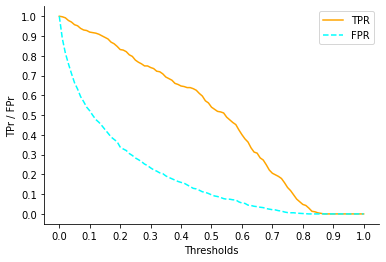

In [35]:
# visualize ROC curve

def roc_c(t, tpr, fpr):
    plt.figure(figsize=(6, 4))
    
    # plot
    plt.plot(t, tpr, color='orange', linestyle='solid', label='TPR')
    plt.plot(t, fpr, color='cyan', linestyle='dashed', label='FPR')

    #decorate
    plt.legend()
    plt.xticks(np.linspace(0, 1, 11))
    plt.yticks(np.linspace(0, 1, 11))
    plt.xlabel('Thresholds')
    plt.ylabel('TPr / FPr')
    plt.gca().spines[['top', 'right']].set_visible(False);
    
# roc curve
roc_c(rates_df_bsc.threshold, rates_df_bsc.tpr, rates_df_bsc.fpr)

An ideal threshold would typically maximize TPr while keeping FPr to lowest possible. From above plot alone we can conclude that classification thresholds of 0.4-0.5 seems to be good candidates for our basic model, or isn't it?

One benefit of ROC curve is comparability across different models, so we can benchmark our basic model performance against several others; for the purpose of demonstration we will manually generate predictions that mimic the performance of a dummy (random) and an ideal model.

In [36]:
# dummy (random) model
# generate random predictions that are uniformly (normally) distributed
np.random.seed(1)

y_rand = np.random.uniform(0, 1, size=len(y_test))

# random model 
rates_df_rand = rates_df(y_test, y_rand, t)

rates_df_rand[::10].round(3)

,threshold,tp,tn,fn,fp,tpr,fpr
0,0.0,374,0,0,1035,1.000,1.000
10,0.1,330,95,44,940,0.882,0.908
20,0.2,300,206,74,829,0.802,0.801
30,0.3,271,306,103,729,0.725,0.704
40,0.4,228,402,146,633,0.610,0.612
50,0.5,186,501,188,534,0.497,0.516
60,0.6,147,612,227,423,0.393,0.409
70,0.7,111,723,263,312,0.297,0.301
80,0.8,78,829,296,206,0.209,0.199
90,0.9,37,931,337,104,0.099,0.100


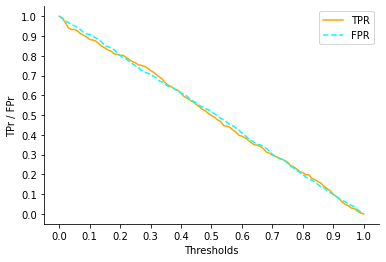

In [37]:
# Visualize random model ROC Curve
roc_c(rates_df_rand.threshold, rates_df_rand.tpr, rates_df_rand.fpr)

Straight line where both TPr and FPr are equal, dummy classifier is not able to distinguish properly between positive and negative class. Check index 50 in rates dataframe.

On the other hand, an ideal model assigns higher weights to positive observations than negative ones when making predictions, thus, **there will be some sort of association between low weights (prediction probability) and negative observations**. Let's generate some ideal predictions where each observation is properly labeled by the classifier.

Notes:
- Weights (prediction probability) refer to class membership probability of 'predict_proba' method.
- AUC is a measure of such association.

In [38]:
# generate ideal predictions

# count of negative and positive examples
neg_obs = (y_test == 0).sum()
pos_obs = len(y_test) - neg_obs

# sorting actual labels 
y_ideal = np.repeat([0, 1], [neg_obs, pos_obs])

# ideal predictions, ascending from 0 to 1
y_pred_ideal = np.linspace(0, 1, len(y_ideal), endpoint=False)

# ideal model
rates_df_ideal = rates_df(y_ideal, y_pred_ideal, t)

rates_df_ideal[::10].round(3)

,threshold,tp,tn,fn,fp,tpr,fpr
0,0.0,374,0,0,1035,1.000,1.000
10,0.1,374,141,0,894,1.000,0.864
20,0.2,374,282,0,753,1.000,0.728
30,0.3,374,423,0,612,1.000,0.591
40,0.4,374,564,0,471,1.000,0.455
50,0.5,374,705,0,330,1.000,0.319
60,0.6,374,846,0,189,1.000,0.183
70,0.7,374,987,0,48,1.000,0.046
80,0.8,281,1035,93,0,0.751,0.000
90,0.9,140,1035,234,0,0.374,0.000


In [39]:
# relationship between sorted label vs prediction proba vs classification threshold of 74%
classification_decision = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]

t_vs_p = pd.DataFrame((y_ideal[-384:-364], y_pred_ideal[-384:-364].round(3), classification_decision)
                     ).T.rename(columns={0:'actual', 1:'pred_proba', 2:'decision'}).round(3).T

t_vs_p

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
actual,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.00,1.00,1.000
pred_proba,0.727,0.728,0.729,0.73,0.73,0.731,0.732,0.732,0.733,0.734,0.735,0.735,0.736,0.737,0.737,0.738,0.739,0.74,0.74,0.741
decision,0.000,0.000,0.000,0.00,0.00,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.00,1.00,1.000


In [40]:
# global average no-churn (priori) 
1 - y_test.mean().round(3)

0.735

We first sorted actual labels then generated predictions in an ascending order; this means that most of negative observations will be associated with low prediction probability and vice versa.

Why? Because this is what predictions of a skilled classifier should look like, this means that it is able to discriminate both observations with ease, placing high prediction probability on positive observations and lower probability on negative ones.

Couple of interesting observations:

- Below any given threshold everything is classified as being a negative observation (i.e.: no churn) and vice versa. In our ideal example (predictions are well sorted against class labels) the negative observations occupy only 73% of all observations (global no churn mean is 73%), then we'd expect that some positive observations (i.e.: churn) will be classified as being negative (i.e.: no-churn) if we increase classification threshold above 73%; because we'd be including some of the positive observations into such classification. Check indices 10 --> 19 in 't_vs_p'

- Skilled classifier places more weights (prediction probability) on positive observations, which means that whenever two observations are randomly chosen the positive observation will always have higher weight (prediction probability) than negative one. This is reflected in the absence of FN observations up to classification threshold of 0.7 with TPr (recall) = 100%, which starts to increase with the increase in threshold as the classifier *miss* some positive observations, as mentioned above, resulting in reduction in recall equivalent to number of missed observations. Check index 70 & 80 in 'rates_df_ideal'.

- Optimal threshold shifted from being in the range of 0.5 in basic model to being in the range of 0.7 in ideal model where TPr is maximized while FPr is at its lowest possible.

Notes:
- As noted earlier when capturing prediction probability of a model, we are only interested in that related to positive observation; so when we say that *a skilled classifier assigns higher probability for positive class* it needs to be understood within this context. If model assigns high probability of being a positive observation to an actual negative observation then this model is not skilled.

In [41]:
# optimal threshold - ideal model
rates_df_ideal[(rates_df_ideal.threshold >=  0.7) & (rates_df_ideal.threshold <  0.8)].round(3)

,threshold,tp,tn,fn,fp,tpr,fpr
70,0.70,374,987,0,48,1.000,0.046
71,0.71,374,1001,0,34,1.000,0.033
72,0.72,374,1015,0,20,1.000,0.019
73,0.73,374,1029,0,6,1.000,0.006
74,0.74,366,1035,8,0,0.979,0.000
75,0.75,352,1035,22,0,0.941,0.000
76,0.76,338,1035,36,0,0.904,0.000
77,0.77,324,1035,50,0,0.866,0.000
78,0.78,309,1035,65,0,0.826,0.000
79,0.79,295,1035,79,0,0.789,0.000


It might be confusing thought when we say that *skilled classifier places more weights on positive observations* and at the same time we note large number of FP moving towards higher threshold; to clear this confusion think of threshold as a limit that follows class distribution, what happens within that limit is a measure of classifier performance.

Example: at threshold 0.7 we capture all positive observations and most of negative observations too (positive observations are only 27% of total observations), the classifier is correctly identifying positive and negative examples (aka higher predict probability for positive examples than negative ones); check index 73.

Summary:

Considering an Ideal model we'd expect:

- Higher weights on positive class than negative ones, picking two random observations at any given threshold the probability of positive class will always be higher.

- If we sort observations the associated weights (prediction probability) will also be similarly sorted. Negative observations will have lower corresponding weights than positive ones.

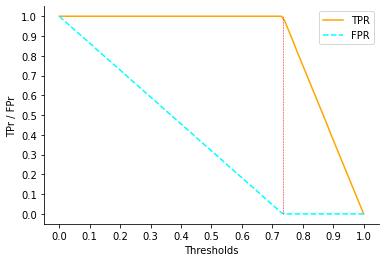

In [42]:
# Visualize ideal model ROC Curve
roc_c(rates_df_ideal.threshold, rates_df_ideal.tpr, rates_df_ideal.fpr)
plt.vlines(1 - y_ideal.mean(), 0, 1, linewidth=0.5, linestyle='dashed', color='red');

TPr is maximized at any given threshold, decline starts following shifting in class distribution.

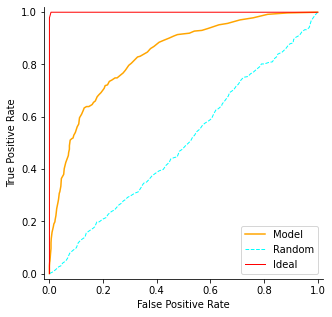

In [43]:
# visualizing all models together

plt.figure(figsize=(5, 5))

plt.plot(rates_df_bsc.fpr, rates_df_bsc.tpr, color='orange', label='Model')
plt.plot(rates_df_rand.fpr, rates_df_rand.tpr, color='cyan', lw=1, linestyle='dashed', label='Random')
plt.plot(rates_df_ideal.fpr, rates_df_ideal.tpr, color='red', lw=1, linestyle='solid', label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.gca().spines[['top', 'right']].set_visible(False);

When plotting ROC curve we're interested in TPr vs FPr, threshold starts at 1 (cords 0, 0) and decrease till 0 (cords 1,1). We want our model to behave as closely as possible to an ideal model because now we understand that this high curve means strong discriminatory power, but how to quantify this power? Using AUC.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='auc'></a>

##### AUC

AUC is a **sorting-based algorithm** that measure how well predictions are sorted. We previously mentioned and demonstrated the relationship between sorting and model performance, if a classifier is skillful there should be some correspondence between positive observations and high prediction probability. In contrast, if the classifier has no skill, the ordering should be random.

The ideal model discussed previously is rarely applicable due to classification errors; this means that negative observations will receive higher prediction probability than positive ones in some cases, which will be captured if observations and corresponding predictions are sorted. 

Using a sorting algorithm such as AUC we can obtain a quantitative measure of model performance based on how well predictions are sorted which reflects model's ability to distinguish between positive and negative examples based on the assigned weights (prediction probability), the better the model the higher the weights for positive observations than negative ones. What kind of sorcery is this!

This means that higher AUC = high prediction probability for positive observations = better model performance, this is the relationship we'll try to understand next.

In the upcoming demonstration we will assume the following:

- Each prediction is considered in turn.
- There are no ties (prediction probability for positive and negative observations are not equal), if ties exist calculations will be slightly different but within the same context so it won't affect our understanding.

How it works:

- Area is gained whenever a positive observation has a higher associated prediction probability than **any** of the negative ones
- No area is gained for negative observations
- For each positive observation, the area gained is a function of the number of negative observations having a higher prediction probability than the current positive observation and the total observations 
- The sum of negative observations with higher prediction probability than each positive one can be obtained from the **ranks** of the weights (prediction probability) corresponding to each positive observation.

In [44]:
# Toy data

# ideal classifier
ideal_df = pd.DataFrame(data = {'actual': [0,0,0,0,1,1,1,1,1], 'pred_proba': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]})

# normal classifier
normal_df = pd.DataFrame(data = {'actual': [1,0,0,1,1,0,1,0,0], 'pred_proba': [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]})

display('Ideal classifier:', ideal_df.T, 'Normal classifier:', normal_df.T)

'Ideal classifier:'

,0,1,2,3,4,5,6,7,8
actual,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
pred_proba,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9


'Normal classifier:'

,0,1,2,3,4,5,6,7,8
actual,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
pred_proba,0.9,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1


In [45]:
# area gained vs inversions

# (negative examples - inversions) / total observation pairs
print('area @ no-inversion:', (5 - 0) / (5 * 4) , '\n'
      'area @ each inversion:', (5 - 2) / (5 * 4) , (5 - 2) / (5 * 4) , (5 - 3) / (5 * 4))

area @ no-inversion: 0.25 
area @ each inversion: 0.15 0.15 0.1


In [46]:
# total area gained (AUC) for normal classifier
((5 - 0) + (5 - 2) + (5 - 2) + (5 - 3)) / (5 * 4)

0.65

In [47]:
# AUC - Normal vs Ideal classifier

# total positive examples
n1 = normal_df.actual.sum()
n0 = normal_df.actual.count() - n1

print('AUC - Ideal Classifier: ', 1 - 0 / (n1*n0), '\n' , 'AUC - Normal Classifier: ', 1 - 7 / (n1*n0), sep = '')

AUC - Ideal Classifier: 1.0
AUC - Normal Classifier: 0.65


In [48]:
# AUC - sklearn
auc_ideal = roc_auc_score(ideal_df.actual, ideal_df.pred_proba)
auc_normal = roc_auc_score(normal_df.actual, normal_df.pred_proba)

print('AUC - Ideal Classifier: ', auc_ideal, '\n' , 'AUC - Normal Classifier: ',  auc_normal.round(2), sep = '')

AUC - Ideal Classifier: 1.0
AUC - Normal Classifier: 0.65


Considering Normal classifier as an example:

There are 4 positive and 5 negative observations forming a total of 20 (5 * 4) pairs of randomly selected observations (one from each class), a skilled classifier would have higher probabilities associated with the positive observations than those associated with negative ones. 

Area is: 
- Gained whenever a positive observation has a higher associated prediction probability than *any* of the negative ones,
- Gain is maximized with the absence of inversion

We can calculate area gained as:

$\frac {n_0 - f}{n_0n_1}$

Where:

- $n_1$ = total positive observations 
- $n_0$ = total negative observations
- $f$ is inversion, how many times negative observation**s** had higher prediction probability than the *current* positive one?

Total area (AUC) can then be derived as:

1 - $\frac{F}{n_0n_1}$

where:

$F$ is the summed number of cases where the prediction probability of a positive observation was exceeded by that of negative ones. Such reversal in order is termed *inversion* in the literature of sorting algorithms; in our example there are 7 inversion occurrences as follows (0 based indexing):
- 3 from Index 1 vs 3, 4 and 6
- 3 from Index 2 vs 3, 4 and 6
- 1 from Index 5 vs 6

Summary:

- Skilled classifier associates higher prediction probability to positive observations
- AUC is a sorting algorithm; its score reflects how well higher prediction probabilities are associated with positive observations
- Each positive observation having higher associated prediction probability than *any* of negative ones contribute to the AUC
- Inversions decrease the area gained
- Minimum value of $F$ is achieved when **all** positive observations have higher prediction probability than **all** negative ones. In this case the value of $F$ is 0 which corresponds to a AUC of 1.0; this can be noted from the calculated AUC of ideal classifier.

In [49]:
# using ranks to calculate AUC
# ranks are index of positive examples starting from 1
round(1 - ((1 + 4 + 5 + 7) - n1 * (n1 + 1) / 2) / (n1 * n0), 2)

0.65

We can calculate $F$ (summed number of cases where the prediction probability of a positive observation was exceeded by the prediction probability of negative ones) using ranks of positive observations prediction probabilities, the normal classifier dataset is sorted in descending order so we capture index of each positive observation and substitute $r$ in the following formula:

$F$ = $\sum_{n=1}^{n_1}$ $r_n$ - $\frac{n_1(n_1 + 1)}{2}$

Where:

$r_n$ = ranks of positive examples

Then AUC can be calculated as shown above:

1 - $\frac{F}{n_1 * n_0}$

In [50]:
# Mann–Whitney U-test

# sorting predictions in ascending order and obtaining ranks 
# + 1 because of zero indexing 
ranks = np.argsort(normal_df.pred_proba)[normal_df.actual == 1] + 1

# U-statistic for positive examples
U1 = np.sum(ranks) - n1 * (n1 + 1) / 2

# U-statistic for negative examples
U0 = n1 * n0 - U1

U = U1 + U0

# AUC is equivelant to U statistic
AUC = U1 / (n1 * n0)

# Results
AUC, U1, U0, U

(0.65, 13.0, 7.0, 20.0)

It's worth mentioning that AUC can also be calculated using *Mann-Whitney U test* where *U* statistic is equivalent to AUC. Don't panic, it's easy!

In a nutshell, the null hypothesis (what the test tries to prove) of U test is that the distribution underlying sample x (actual class labels) is the same as the distribution underlying sample y (predicted class label). We calculate U statistic as follows:

$U_1$ = $\sum_{n=1}^{n_1}$ $r_{n}$ - $\frac{n_1(n_1 + 1)}{2}$

$U_0$ = $\sum_{n=1}^{n_0}$ $r_{n}$ - $\frac{n_0(n_0 + 1)}{2}$

$U$ = $U_1$ + $U_0$ = $n_1$ * $n_0$

Where:

$U_1$ is statistic of positive observations
$U_0$ is statistic of negative observations

Then AUC can be derived as:

$AUC$ = $\frac{U_1}{n_1 * n_0}$

Notes:

- $U_1$ is exactly the same calculation as $F$

- Difference between ranks in $F$ and $U_1$ calculation is the sorting, in $F$ we captured ranks after sorting in descending order contrary to what we did in $U_1$

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='sum'></a>

##### Summary - AUC:


To wrap up this interesting topic, let's visualize what does it really mean to say *Area is gained whenever a positive observation has a higher associated prediction probability than any of the negative ones*

Given the pairs of observations from normal dataframe, where each pair includes an observation from each class. We draw a grid of $n_1$ * $n_0$ representing number of positive and negative observations respectively, each grid is labeled according to their **rank** (starting from 1); for each pair we do the following:

- Place tuples of corresponding prediction probability, starting with positive observations followed by negative ones
- Highlight pairs where positive observation is weighted higher than negative ones, these represents instances of correct predictions (positive observation weighted higher than negative one)
- The highlighted area is AUC! 13 highlighted pairs divided by 20 total pairs = 0.65.

<img class="aligncenter" src="https://drive.google.com/uc?id=19Leb8LI1uOGPxOOY5FmFcSm19RMYLXyD" width="600" height="600">

Closing statement:
- AUC is the **probability** that a randomly chosen positive observation ranks higher than a randomly chosen negative one.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**

<a id='thre'></a>

#### Threshold moving - Enhanced

We've briefly introduced threshold moving earlier and now we can enhance such approach utilizing other metrics discussed along with associated cost of errors.

'Which threshold to choose?' can be better answered by asking 'what do we want our classifier to do?' Let's consider our churn problem, if a customer churn then we've lost revenue at the same time if we target loyal customers (no intention to churn) with incentives directed to potential churning customers then we've incurred excess cost.

High Recall will help in capturing all potential churning customers but also may result in higher false positives (misdirecting incentives), while high precision will help target potential churning customers correctly but may result in higher false negatives (missing churning customers). There will always be a tradeoff between both metric, knowing associated costs of misclassification errors (false positives and false negatives) can help us make guided decision on which threshold to choose.

Another complication is the imbalanced nature of observations, rendering some metric useless. FN (predicted No-churn but actual churn) errors are more costly than FP (predicted churn but actual no-churn) errors because for the former we lost a portion of revenue while for the latter we misdirected some of incentives to loyal customers; we'll consider that the cost of losing a customer (FN) out weights that of making both customers happy (FP - misdirecting some of incentives) and let overall cost guide our decision.

Let's construct a decision guidance table including all metrics discussed earlier and the associated cost of miss-classification errors for proper comparison.

In [51]:
# Threshold moving - the full picture

metric = []

for _ in t:

    # assigning class label above given threshold
    y_pred_c = (y_pred >= _).astype(int)
    
    # metric calculation
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_c).ravel()
    if (tp + fp) == 0: # avoiding zero division
        pr = 0
    else:
        pr = tp / (tp + fp) # precision
    rec = tp / (tp + fn) # recall / true positive rate
    fpr = fp / (fp + tn) # false positive rate
    err_rate = (fp + fn) / len(y_pred_c) 
    
    # update list
    metric.append((tn, fp, fn, tp, err_rate, pr, rec, fpr, _))

# metric dataframe 
metric_df = pd.DataFrame(metric, columns=['tn', 'fp', 'fn', 'tp', 'err_rate', 'precision', 'recall', 'fpr', 'threshold'])    

# estimated error cost
metric_df['fp_cost'], metric_df['fn_cost'] = metric_df.fp * 10, metric_df.fn * 100
metric_df['total_misclss_cost'] = metric_df.fp_cost + metric_df.fn_cost

In [52]:
# Display Results

print('ROC_AUC: ', roc_auc_score(y_test, y_pred).round(2), '\n', 'PR_AUC: ', auc(metric_df.recall, metric_df.precision).round(2), 
      sep = '')

metric_df[::10].style.format('{:,.2f}').apply(lambda x: ['background: purple' if x.name in [10,20,50] else '' for i in x], 
                                              axis = 1)

ROC_AUC: 0.83
PR_AUC: 0.66


,tn,fp,fn,tp,err_rate,precision,recall,fpr,threshold,fp_cost,fn_cost,total_misclss_cost
0,0.00,"1,035.00",0.00,374.00,0.73,0.27,1.00,1.00,0.00,"10,350.00",0.00,"10,350.00"
10,495.00,540.00,30.00,344.00,0.40,0.39,0.92,0.52,0.10,"5,400.00","3,000.00","8,400.00"
20,685.00,350.00,63.00,311.00,0.29,0.47,0.83,0.34,0.20,"3,500.00","6,300.00","9,800.00"
30,794.00,241.00,97.00,277.00,0.24,0.53,0.74,0.23,0.30,"2,410.00","9,700.00","12,110.00"
40,870.00,165.00,132.00,242.00,0.21,0.59,0.65,0.16,0.40,"1,650.00","13,200.00","14,850.00"
50,935.00,100.00,172.00,202.00,0.19,0.67,0.54,0.10,0.50,"1,000.00","17,200.00","18,200.00"
60,978.00,57.00,224.00,150.00,0.20,0.72,0.40,0.06,0.60,570.00,"22,400.00","22,970.00"
70,"1,013.00",22.00,297.00,77.00,0.23,0.78,0.21,0.02,0.70,220.00,"29,700.00","29,920.00"
80,"1,033.00",2.00,356.00,18.00,0.25,0.90,0.05,0.00,0.80,20.00,"35,600.00","35,620.00"
90,"1,035.00",0.00,374.00,0.00,0.27,0.00,0.00,0.00,0.90,0.00,"37,400.00","37,400.00"


Adding costs to confusion matrix enabled monetization of predictions errors, these costs are estimates based on our belief that FN errors outweighs FP ones.

At threshold 0 and 1 we obtain cost of not using predictive modeling, either sending incentives to all customers (t = 0) or just ignore the situation (t = 1), in between is the value our model brings. We can go for higher recall over precision (t = .1 or .2) or a take a more balanced route (t = .5).

It's interesting to note how significantly ROC_AUC varies from PR_AUC, precision recall (PR) curve focus on positive observations (minority class in imbalanced classification) and portrays less optimistic view of model performance given that ROC curve is shadowed by the large number of negative observations (majority class).

Clearly our model needs improvement; we can now compare our model as is to subsequent adjustments or even different models.

**<a href="#Toc" style='color:#00ffff'>Table of contents</a>**